# Task 1

In [2]:
# Task 1
# Imports
from pgmpy.factors.discrete import TabularCPD
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
import network_map
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import K2Score
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.estimators import HillClimbSearch,BicScore,ConstraintBasedEstimator,K2Score
from pgmpy.estimators import MaximumLikelihoodEstimator
import pandas as pd

In [3]:
edges_list = network_map.edges_list
nodes_list = network_map.nodes_list
cpds_list = network_map.cpds_list
marginal_list = network_map.marginal_list

In [4]:
# Functions
def independence_test(condVar,varY,stateX,stateY,cpd_val,marginal_list):
    stateY = int(stateY)
    stateX = int(stateX)
    prob_Y_given_X = cpd_val[stateY][stateX]
    marginal_X = marginal_list[condVar][stateX]
    lhs = np.multiply(prob_Y_given_X,marginal_X)
    marginal_Y = marginal_list[varY][stateY]
    rhs = np.multiply(marginal_Y,marginal_X)
    return (np.abs(lhs-rhs))

def accio_cpd_table(_cond_var):
    '''
    Lookup the CPD table for a given Variable
    Returns the table in which the dist is encoded in
    '''
    switch_cpd_dict_given = {'x1':0,'x2':1,'x3':2,'x4':3,'x5':4,'x6':5}
    table = switch_cpd_dict_given[_cond_var]
    return table

def accio_state_table(_var,nodes_list):
    switch_node_dict = {'x1':0,'x2':0,'x3':1,'x4':0,'x5':1,'x6':2}
    states_possible = switch_node_dict[_var]
    states_possible = len(list(nodes_list[switch_node_dict[_var]][_var].values())[0].keys())
    return states_possible

def find_cpd_defined_or_not(varA,givenVar):
    for _cpds in cpds_list[accio_cpd_table(givenVar)]:
        if varA in _cpds["Variables"].keys():
            return "D"
    for _cpds in cpds_list[accio_cpd_table(varA)]:
        if givenVar in _cpds["Variables"].keys():
            return "B"
    return "I"

def find_given(_varA,_cond_var,_cond_var_state,_varA_state,cpds_list,marginal_list,ind_dict):
    '''
    Finds if a variable is dependent or not on the assumption in the paper that any variables
    not present in the cpd tables are independent
    '''
    # Find given values
    _cpds = cpds_list[accio_cpd_table(_cond_var)]
    if(ind_dict[_varA] == 'I'):
        #print("Marg")
        # Discarding Cond Var and marg lookup
        return marginal_list[_varA][_varA_state]
    elif(ind_dict[_varA] == 'B'):
        # Bayes theorem
        for _cpd in cpds_list[accio_cpd_table(_varA)]:
            if _cond_var in _cpd["Variables"]:
                #print(_cpd)
                left = _cpd["Values"][_cond_var_state][_varA_state]
        #print(_varA,_cond_var)
        right = marginal_list[_varA][_varA_state]
        #print(left,",",right)
        num = np.multiply(left,right)
        deno = marginal_list[_cond_var][_cond_var_state]
        #print(np.divide(num,deno))
        return np.divide(num,deno)
    elif(ind_dict[_varA] == 'D'):
        #print("Cond Lookup")
        for _cpd in _cpds:
            if _varA in _cpd["Variables"]:
                return _cpd["Values"][_varA_state][_cond_var_state]
            
def v_structure_cpd(cond_var,random_var):
    # Need recursion for future to decompose multiple nodes
    '''
    Toy example:
    We have P(Y | X1,X2)
    1. Finding Conditionals: P(X1 | Y), P(X2 | Y), P(X1 | X2)
    2. Finding Marginals: P(Y), P(X2)
    Finding 60 variables
    '''
    # Defining Lambda functions to handle divide by zero error adding small value during lookups
    zeroProb = lambda x: x+ 0.00000001
    loop = lambda x: zeroProb(x) if x==0 else x
    # How to find which table corresponds to the rand var? See the function desc for more details
    table = accio_cpd_table(random_var)

    # Finding the states of the rand var and cond var
    switch_node_dict = {'x1':0,'x2':0,'x3':1,'x4':0,'x5':1,'x6':2}
    _state_dict = {}
    _random_var_states = len(list(nodes_list[switch_node_dict[random_var]][random_var].values())[0].keys())
    for _cond_var in cond_var:
        _state_dict[_cond_var] = len(list(nodes_list[switch_node_dict[_cond_var]][_cond_var].values())[0].keys())

    # Independent dict to keep track of the variables which are dependent on the paper assumption
    ind_dict = {}
    for _cond_var in cond_var:
        ind_dict[_cond_var] = find_cpd_defined_or_not(_cond_var,random_var)
    # Skeleton of the resulting CPD
    x2_given_x1_x3_cpd = [[] for i in range(_random_var_states)]
    #print(_random_var_states)
    #print(_state_dict)
    i = 0  # Diags
    for Y_state in range(_random_var_states):
        for X2_state in range(_state_dict[cond_var[1]]):
            for X1_state in range(_state_dict[cond_var[0]]):
                i +=1  # Diags
                X1_given_Y = loop(find_given(_varA=cond_var[0],_cond_var=random_var,
                                 _varA_state=X1_state,_cond_var_state=Y_state,
                                 cpds_list=cpds_list,marginal_list=marginal_list,ind_dict=ind_dict))
                X2_given_Y = loop(find_given(_varA=cond_var[1],_cond_var=random_var,
                                       _varA_state=X2_state,_cond_var_state=Y_state,
                                       cpds_list=cpds_list,marginal_list=marginal_list,ind_dict=ind_dict))
                Y = loop(marginal_list[random_var][Y_state])
                '''
                Depends on the case if x1 and x2 are independent then use P(x).P(y) = P(x,y) or else have to use 
                P(x,y) = P(x | y). P(y)'''
                # Redifine
                if(find_cpd_defined_or_not(cond_var[0],cond_var[1]) == 'I'):
                    X1_X2 = loop(np.multiply(marginal_list[cond_var[0]][X1_state],marginal_list[cond_var[1]][X2_state]))
                else:
                    #print(find_cpd_defined_or_not(cond_var[0],cond_var[1]))
                    ind_dict2={cond_var[0]:find_cpd_defined_or_not(cond_var[0],cond_var[1])}
                    X1_X2 = loop(find_given(_varA=cond_var[0],_cond_var=cond_var[1],
                                 _varA_state=X1_state,_cond_var_state=X2_state,
                                 cpds_list=cpds_list,marginal_list=marginal_list,ind_dict=ind_dict2))
                    #print(X1_X2)
                num = np.multiply(X1_given_Y,X2_given_Y)
                num = np.multiply(num,Y)
                deno = X1_X2
                x2_given_x1_x3_cpd[Y_state].append(np.divide(num,deno))
    cpd = TabularCPD(random_var,_random_var_states, np.array(x2_given_x1_x3_cpd),[cond_var[1],cond_var[0]], [_state_dict[cond_var[1]],_state_dict[cond_var[0]]])
    if(not cpd.is_valid_cpd()):
        cpd.normalize(inplace=True)
    cpd = TabularCPD(random_var,_random_var_states, np.array(np.round(cpd.get_values(),4)), [cond_var[1],cond_var[0]], [_state_dict[cond_var[1]],_state_dict[cond_var[0]]])
    return cpd

In [5]:
numTables = 6
for table in range(numTables):
    _edges = edges_list[table]
    _nodes = nodes_list[table]
    _cpds = cpds_list[table]
    for cpd in _cpds:
        varY = list(cpd["Variables"].keys())[0]
        condVar = list(cpd["Variables"].values())[0][0]
        cpd_val = cpd['Values']
        print(varY,",",condVar)
        lOne = []
        for stateY in _nodes[varY]['States'].keys():
            for stateX in _nodes[condVar]['States'].keys():
                lOne.append(independence_test(condVar,varY,stateX,stateY,cpd_val,marginal_list))
        print(np.sum(lOne))

x2 , x1
0.15977000000000002
x4 , x1
0.11943000000000005
x6 , x1
0.16015500000000005
x3 , x2
0.21852500000000008
x5 , x2
0.13246000000000005
x2 , x3
0.21875800000000004
x5 , x3
0.11551999999999997
x6 , x3
0.11324000000000001
x1 , x4
0.11957000000000005
x2 , x4
0.11569999999999997
x6 , x4
0.14347
x2 , x5
0.12939
x3 , x5
0.11596500000000003
x1 , x6
0.16036999999999998
x2 , x6
0.17531500000000003
x3 , x6
0.09434000000000006
x4 , x6
0.14306999999999997


# Task 2

## Network 1

In [6]:
nodes_list_nw = {
        'x1':{
            'States': {
                '0':{},
                '1':{},
                '2':{},
                '3':{}
            }
        },
        'x2':{
        'States':{
            '0':{},
            '1':{},
            '2':{},
            '3':{},
            '4':{}
        }
        },
        'x3':{
        'States':{
            '0':{},
            '1':{},
            '2':{}
        }
        },
        'x4':{
        'States':{
            '0':{},
            '1':{},
            '2':{},
            '3':{}
        }
        },
        'x5':{
        'States':{
            '0':{},
            '1':{},
            '2':{},
            '3':{}
        }
        },
        'x6':{
        'States':{
            '0':{},
            '1':{},
            '2':{},
            '3':{},
            '4':{}
        }
        }
    }

In [7]:
x2_given_x5_x6= v_structure_cpd(['x5','x6'],'x2')

edges_list_nw = [
    [('x5','x2'),
    ('x3','x5'),
    ('x6','x2'),
    ('x6','x1'),
    ('x6','x4')]
]

cpds_list_nw = [
    [
        {
        'Values': cpds_list[accio_cpd_table('x3')][1]['Values'],
        'Variables':{'x5':['x3']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][0]['Values'],
        'Variables':{'x1':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][3]['Values'],
        'Variables':{'x4':['x6']}
        },
        {
        'Values': x2_given_x5_x6.get_values(),
        'Variables': {'x2':['x5','x6']}
        },
        {
        'Values': np.array(marginal_list['x3']),
        'Variables':{'x3':[]}
        },
                {
        'Values': np.array(marginal_list['x6']),
        'Variables':{'x6':[]}
        }
    ]
]


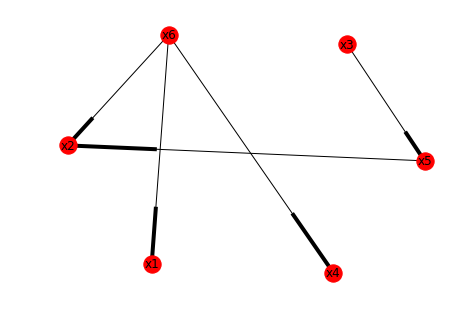

In [9]:
'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list[table]
_cpds = cpds_list_nw[table]
nw1 = BayesianModel(_edges)

for node in _nodes:
    #model.node[node] = nodes[node]
    nw1.node[node].update(_nodes[node])

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][3]['Values'],['x6','x5'],[accio_state_table('x6',nodes_list),accio_state_table('x5',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),[cpds_list_nw[0][4]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),cpds_list_nw[0][0]['Values'],['x3'],[accio_state_table('x3',nodes_list)]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),cpds_list_nw[0][1]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),cpds_list_nw[0][2]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))

nw1.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw1, with_labels=True)
plt.show()

## Network 2

In [10]:
cpds_list[accio_cpd_table('x6')][2]['Values']

array([[0.   , 0.218, 0.107, 0.206, 0.143],
       [1.   , 0.656, 0.714, 0.635, 0.643],
       [0.   , 0.125, 0.179, 0.159, 0.214]])

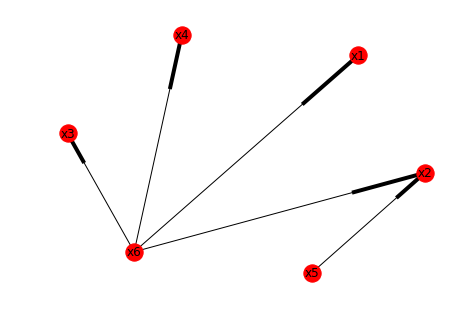

In [11]:
x2_given_x5_x6= v_structure_cpd(['x5','x6'],'x2')

edges_list_nw = [
    [('x5','x2'),
     ('x6','x2'),
     ('x6','x3'),
     ('x6','x4'),
     ('x6','x1'),
    ]
]

cpds_list_nw = [
    [
        {
        'Values': cpds_list[accio_cpd_table('x6')][2]['Values'],
        'Variables':{'x3':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][0]['Values'],
        'Variables':{'x1':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][3]['Values'],
        'Variables':{'x4':['x6']}
        },
        {
        'Values': x2_given_x5_x6.get_values(),
        'Variables': {'x2':['x5','x6']}
        },
        {
        'Values': np.array(marginal_list['x5']),
        'Variables':{'x5':[]}
        },
                {
        'Values': np.array(marginal_list['x6']),
        'Variables':{'x6':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list[table]
_cpds = cpds_list_nw[table]
nw2 = BayesianModel(_edges)

for node in _nodes:
    #model.node[node] = nodes[node]
    nw2.node[node].update(_nodes[node])

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][3]['Values'],['x6','x5'],[accio_state_table('x6',nodes_list),accio_state_table('x5',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),[cpds_list_nw[0][4]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),cpds_list_nw[0][0]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),cpds_list_nw[0][1]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),cpds_list_nw[0][2]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))

nw2.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw2, with_labels=True)
plt.show()

## Network 3

In [12]:
x2_given_x1_x3= v_structure_cpd(['x1','x3'],'x2')

In [13]:
cpds_list[accio_cpd_table('x2')][1]

{'Values': array([[0.418, 0.334, 0.6  , 0.382, 0.334],
        [0.073, 0.109, 0.4  , 0.147, 0.095],
        [0.109, 0.125, 0.   , 0.118, 0.071],
        [0.4  , 0.422, 0.   , 0.353, 0.5  ]]), 'Variables': {'x5': ['x2']}}

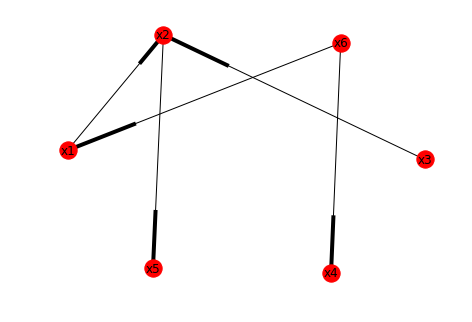

In [14]:
edges_list_nw = [
    [('x2','x5'),
     ('x6','x1'),
     ('x3','x2'),
     ('x6','x4'),
     ('x1','x2'),
    ]
]

cpds_list_nw = [
    [
        {
        'Values': cpds_list[accio_cpd_table('x6')][0]['Values'],
        'Variables':{'x1':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x2')][1]['Values'],
        'Variables':{'x5':['x2']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][3]['Values'],
        'Variables':{'x4':['x6']}
        },
        {
        'Values': x2_given_x1_x3.get_values(),
        'Variables': {'x2':['x1','x3']}
        },
        {
        'Values': np.array(marginal_list['x3']),
        'Variables':{'x5':[]}
        },
                {
        'Values': np.array(marginal_list['x6']),
        'Variables':{'x6':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list[table]
_cpds = cpds_list_nw[table]
nw3 = BayesianModel(_edges)

for node in _nodes:
    #model.node[node] = nodes[node]
    nw3.node[node].update(_nodes[node])

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][3]['Values'],['x3','x1'],[accio_state_table('x3',nodes_list),accio_state_table('x1',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),[cpds_list_nw[0][4]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),cpds_list_nw[0][1]['Values'],['x2'],[accio_state_table('x2',nodes_list)]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),cpds_list_nw[0][0]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),cpds_list_nw[0][2]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))

nw3.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw3, with_labels=True)
plt.show()

## Network 4

In [15]:
'''
Minimum Nodes using x5 and x4 as independent
'''

'\nMinimum Nodes using x5 and x4 as independent\n'

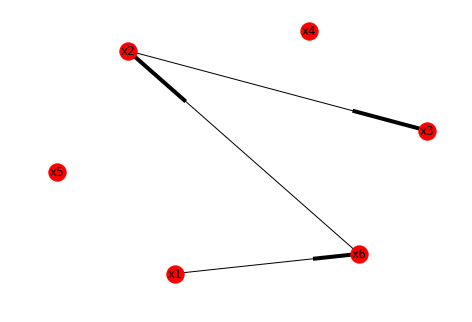

In [16]:
edges_list_nw = [
    [('x2','x3'),
     ('x6','x2'),
     ('x1','x6')
    ]
]


cpds_list_nw = [
    [
        {
        'Values': cpds_list[accio_cpd_table('x6')][1]['Values'],
        'Variables':{'x2':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x2')][0]['Values'],
        'Variables':{'x3':['x2']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x1')][2]['Values'],
        'Variables':{'x6':['x1']}
        },
        {
        'Values': np.array(marginal_list['x1']),
        'Variables':{'x1':[]}
        },
        {
        'Values': np.array(marginal_list['x4']),
        'Variables':{'x4':[]}
        },
        {
        'Values': np.array(marginal_list['x5']),
        'Variables':{'x5':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list_nw
_cpds = cpds_list_nw[table]
nw4 = BayesianModel(_edges)

for nodes in _nodes:
    nw4.add_node(nodes)

tabular_cpds = []
# Marginals
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),[cpds_list_nw[0][4]['Values']]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),[cpds_list_nw[0][3]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),cpds_list_nw[0][1]['Values'],['x2'],[accio_state_table('x2',nodes_list)]))
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][0]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),cpds_list_nw[0][2]['Values'],['x1'],[accio_state_table('x1',nodes_list)]))

nw4.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw4, with_labels=True)
plt.show()

## Network 5

In [18]:
'''
Finding x6 given x2 using Bayes Theorem
'''
condVar = 'x2'
randVar = 'x6'
ind_dict = {}
ind_dict[randVar] = find_cpd_defined_or_not(randVar,condVar)
ind_dict
x6_given_x2 = [[] for i in range(accio_state_table('x6',nodes_list)) ]
for condState in range(accio_state_table('x2',nodes_list)):
    for randVarState in range(accio_state_table('x6',nodes_list)):
        val = find_given(_varA='x6',_cond_var='x2',
                   _varA_state=randVarState,_cond_var_state=condState,
                   cpds_list=cpds_list,marginal_list=marginal_list,ind_dict=ind_dict)
        x6_given_x2[randVarState].append(val)
x6_given_x2 = np.array(x6_given_x2)

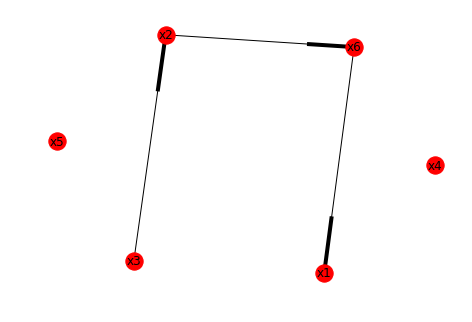

In [19]:
edges_list_nw = [
    [('x3','x2'),
     ('x6','x1'),
     ('x2','x6')
    ]
]


cpds_list_nw = [
    [
        {
        'Values': x6_given_x2,
        'Variables':{'x6':['x2']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x3')][0]['Values'],
        'Variables':{'x2':['x3']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][0]['Values'],
        'Variables':{'x1':['x6']}
        },
        {
        'Values': np.array(marginal_list['x3']),
        'Variables':{'x3':[]}
        },
        {
        'Values': np.array(marginal_list['x4']),
        'Variables':{'x4':[]}
        },
        {
        'Values': np.array(marginal_list['x5']),
        'Variables':{'x5':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list_nw
_cpds = cpds_list_nw[table]
nw5 = BayesianModel(_edges)

for nodes in _nodes:
    nw5.add_node(nodes)

tabular_cpds = []
# Marginals
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),[cpds_list_nw[0][4]['Values']]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),[cpds_list_nw[0][3]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][1]['Values'],['x3'],[accio_state_table('x3',nodes_list)]))
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),cpds_list_nw[0][0]['Values'],['x2'],[accio_state_table('x2',nodes_list)]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),cpds_list_nw[0][2]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))

nw5.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw5, with_labels=True)
plt.show()

## Network 6

In [20]:
x2_given_x1_x3= v_structure_cpd(['x3','x6'],'x2')

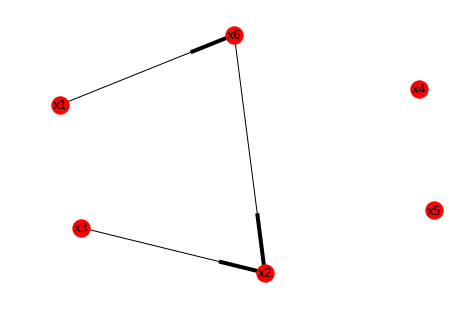

In [21]:
edges_list_nw = [
    [('x3','x2'),
     ('x6','x2'),
     ('x1','x6')
    ]
]


cpds_list_nw = [
    [
        {
        'Values': x2_given_x1_x3.get_values(),
        'Variables':{'x2':['x3','x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x1')][2]['Values'],
        'Variables':{'x6':['x1']}
        },
        {
        'Values': np.array(marginal_list['x1']),
        'Variables':{'x1':[]}
        },
        {
        'Values': np.array(marginal_list['x3']),
        'Variables':{'x3':[]}
        },
        {
        'Values': np.array(marginal_list['x4']),
        'Variables':{'x4':[]}
        },
        {
        'Values': np.array(marginal_list['x5']),
        'Variables':{'x5':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list_nw
_cpds = cpds_list_nw[table]
nw6 = BayesianModel(_edges)

for nodes in _nodes:
    nw6.add_node(nodes)

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][0]['Values'],['x6','x3'],[accio_state_table('x6',nodes_list),accio_state_table('x3',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),[cpds_list_nw[0][4]['Values']]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),[cpds_list_nw[0][2]['Values']]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),[cpds_list_nw[0][3]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),cpds_list_nw[0][1]['Values'],['x1'],[accio_state_table('x1',nodes_list)]))

nw6.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw6, with_labels=True)
plt.show()

In [22]:
'''
We can't keep x5 and x4 independent because K2 is bad
'''

"\nWe can't keep x5 and x4 independent because K2 is bad\n"

## Network 7 

{'Values': array([[1.   , 0.625, 0.786, 0.746, 0.738],
        [0.   , 0.187, 0.107, 0.063, 0.048],
        [0.   , 0.   , 0.   , 0.016, 0.024],
        [0.   , 0.187, 0.107, 0.175, 0.19 ]]), 'Variables': {'x4': ['x6']}}

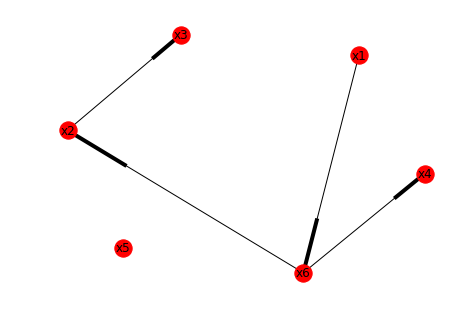

In [139]:
edges_list_nw = [
    [('x2','x3'),
     ('x6','x2'),
     ('x1','x6'),
     ('x6','x4')
    ]
]


cpds_list_nw = [
    [
        {
        'Values': cpds_list[accio_cpd_table('x6')][1]['Values'],
        'Variables':{'x2':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][3]['Values'],
        'Variables':{'x4':['x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x1')][2]['Values'],
        'Variables':{'x6':['x1']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x2')][0]['Values'],
        'Variables':{'x3':['x2']}
        },
        {
        'Values': np.array(marginal_list['x1']),
        'Variables':{'x1':[]}
        },
        {
        'Values': np.array(marginal_list['x5']),
        'Variables':{'x5':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list_nw
_cpds = cpds_list_nw[table]
nw7 = BayesianModel(_edges)

for nodes in _nodes:
    nw7.add_node(nodes)

tabular_cpds = []
# Marginals
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),[cpds_list_nw[0][4]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][0]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),cpds_list_nw[0][1]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),cpds_list_nw[0][2]['Values'],['x1'],[accio_state_table('x1',nodes_list)]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),cpds_list_nw[0][3]['Values'],['x2'],[accio_state_table('x2',nodes_list)]))

nw7.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw7, with_labels=True)
plt.show()

## Network 8

In [25]:
# Two V-Structures !!

In [26]:
x2_given_x3_x5= v_structure_cpd(['x3','x5'],'x2')
x6_given_x2_x4= v_structure_cpd(['x2','x4'],'x6')

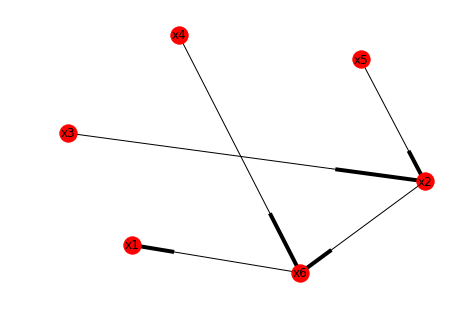

In [27]:
edges_list_nw = [
    [('x3','x2'),
     ('x2','x6'),
     ('x5','x2'),
     ('x6','x1'),
     ('x4','x6')
    ]
]


cpds_list_nw = [
    [
        {
        'Values': x2_given_x3_x5.get_values(),
        'Variables':{'x2':['x3','x5']}
        },
        {
        'Values': x6_given_x2_x4.get_values(),
        'Variables':{'x6':['x2','x4']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x6')][0]['Values'],
        'Variables':{'x1':['x6']}
        },
        {
        'Values': np.array(marginal_list['x3']),
        'Variables':{'x3':[]}
        },
        {
        'Values': np.array(marginal_list['x4']),
        'Variables':{'x4':[]}
        },
        {
        'Values': np.array(marginal_list['x5']),
        'Variables':{'x5':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list_nw
_cpds = cpds_list_nw[table]
nw8 = BayesianModel(_edges)

for nodes in _nodes:
    nw8.add_node(nodes)

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][0]['Values'],['x5','x3'],[accio_state_table('x5',nodes_list),accio_state_table('x3',nodes_list)]))
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),cpds_list_nw[0][1]['Values'],['x4','x2'],[accio_state_table('x4',nodes_list),accio_state_table('x2',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),[cpds_list_nw[0][4]['Values']]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),[cpds_list_nw[0][3]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),cpds_list_nw[0][2]['Values'],['x6'],[accio_state_table('x6',nodes_list)]))

nw8.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw8, with_labels=True)
plt.show()

## Network 9

In [28]:
x2_given_x1_x6= v_structure_cpd(['x1','x6'],'x2')
x4_given_x1_x6= v_structure_cpd(['x1','x6'],'x4')

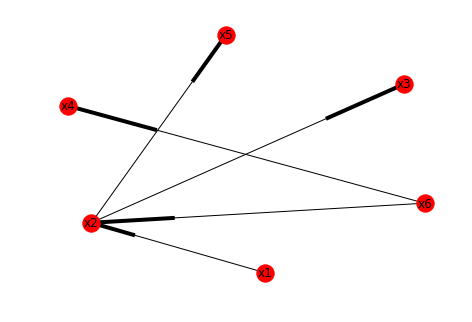

In [29]:
edges_list_nw = [
    [('x2','x3'),
     ('x2','x5'),
     ('x6','x4'),
     ('x1','x2'),
     ('x6','x2')
    ]
]


cpds_list_nw = [
    [
        {
        'Values': x2_given_x1_x6.get_values(),
        'Variables':{'x2':['x1','x6']}
        },
        {
        'Values': x4_given_x1_x6.get_values(),
        'Variables':{'x4':['x1','x6']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x2')][1]['Values'],
        'Variables':{'x5':['x2']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x2')][0]['Values'],
        'Variables':{'x3':['x2']}
        },
        {
        'Values': np.array(marginal_list['x1']),
        'Variables':{'x1':[]}
        },
        {
        'Values': np.array(marginal_list['x6']),
        'Variables':{'x6':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list_nw
_cpds = cpds_list_nw[table]
nw9 = BayesianModel(_edges)

for nodes in _nodes:
    nw9.add_node(nodes)

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][0]['Values'],['x6','x1'],[accio_state_table('x6',nodes_list),accio_state_table('x1',nodes_list)]))
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),cpds_list_nw[0][1]['Values'],['x6','x1'],[accio_state_table('x6',nodes_list),accio_state_table('x1',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),[cpds_list_nw[0][4]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),cpds_list_nw[0][2]['Values'],['x2'],[accio_state_table('x2',nodes_list)]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),cpds_list_nw[0][3]['Values'],['x2'],[accio_state_table('x2',nodes_list)]))

nw9.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw9, with_labels=True)
plt.show()

## Network 10

In [30]:
x2_given_x3_x6= v_structure_cpd(['x3','x6'],'x2')
x6_given_x1_x4= v_structure_cpd(['x1','x4'],'x6')

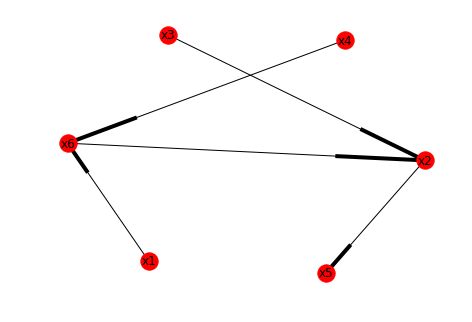

In [31]:
edges_list_nw = [
    [('x3','x2'),
     ('x2','x5'),
     ('x6','x2'),
     ('x4','x6'),
     ('x1','x6')
    ]
]


cpds_list_nw = [
    [
        {
        'Values': x2_given_x3_x6.get_values(),
        'Variables':{'x2':['x3','x6']}
        },
        {
        'Values': x6_given_x1_x4.get_values(),
        'Variables':{'x6':['x1','x4']}
        },
        {
        'Values': cpds_list[accio_cpd_table('x2')][1]['Values'],
        'Variables':{'x5':['x2']}
        },
        {
        'Values': np.array(marginal_list['x1']),
        'Variables':{'x1':[]}
        },
        {
        'Values': np.array(marginal_list['x3']),
        'Variables':{'x3':[]}
        },
        {
        'Values': np.array(marginal_list['x4']),
        'Variables':{'x4':[]}
        }
    ]
]


'''
NW1
'''
table = 0
_edges = edges_list_nw[table]
_nodes = nodes_list_nw
_cpds = cpds_list_nw[table]
nw10 = BayesianModel(_edges)

for nodes in _nodes:
    nw10.add_node(nodes)

tabular_cpds = []
# V Structure
tabular_cpds.append(TabularCPD('x2',accio_state_table('x2',nodes_list),cpds_list_nw[0][0]['Values'],['x6','x3'],[accio_state_table('x6',nodes_list),accio_state_table('x3',nodes_list)]))
tabular_cpds.append(TabularCPD('x6',accio_state_table('x6',nodes_list),cpds_list_nw[0][1]['Values'],['x4','x1'],[accio_state_table('x4',nodes_list),accio_state_table('x1',nodes_list)]))
# Marginals
tabular_cpds.append(TabularCPD('x4',accio_state_table('x4',nodes_list),[cpds_list_nw[0][5]['Values']]))
tabular_cpds.append(TabularCPD('x3',accio_state_table('x3',nodes_list),[cpds_list_nw[0][4]['Values']]))
tabular_cpds.append(TabularCPD('x1',accio_state_table('x1',nodes_list),[cpds_list_nw[0][3]['Values']]))
# Directed Links
tabular_cpds.append(TabularCPD('x5',accio_state_table('x5',nodes_list),cpds_list_nw[0][2]['Values'],['x2'],[accio_state_table('x2',nodes_list)]))

nw10.add_cpds(*tabular_cpds)

#for cpd in nw1.cpds:
    #print(cpd)

# Requires matplotlib < 2.2
import networkx as nx
import pylab as plt
nx.draw(nw10, with_labels=True)
plt.show()

In [155]:
np.random.seed(666)
inference1 = BayesianModelSampling(nw1)
inference2 = BayesianModelSampling(nw5)
inference3 = BayesianModelSampling(nw8)
dataNw1 = inference1.forward_sample(size=10000, return_type='dataframe')
dataNw2 = inference2.forward_sample(size=10000, return_type='dataframe')
dataNw3 = inference3.forward_sample(size=10000, return_type='dataframe')

In [156]:
evalData = pd.concat([dataNw1[['x1','x2','x3','x4','x5','x6']],
          dataNw2[['x1','x2','x3','x4','x5','x6']],
          dataNw3[['x1','x2','x3','x4','x5','x6']]])
evalData = evalData.sample(frac = 1).reset_index(drop=True)

In [157]:
k2 = K2Score(evalData)
networks = [nw1,nw2,nw3,nw4,nw5,nw6,nw7,nw8,nw9,nw10]
k2Scores=[]
for i,network in enumerate(networks):
    k2Scores.append(k2.score(network))
    print("The K2 Score for Network "+str(i+1)+" is :"+str(k2Scores[i]))
print("Network "+str(np.argmax(k2Scores)+1)+" is best")

The K2 Score for Network 1 is :-190217.53227388105
The K2 Score for Network 2 is :-190285.821578102
The K2 Score for Network 3 is :-191041.1161300868
The K2 Score for Network 4 is :-190110.1044252786
The K2 Score for Network 5 is :-190120.93704736367
The K2 Score for Network 6 is :-190205.59798684312
The K2 Score for Network 7 is :-189715.7333347561
The K2 Score for Network 8 is :-189588.72091423522
The K2 Score for Network 9 is :-190404.71793060243
The K2 Score for Network 10 is :-189563.15222515093
Network 10 is best


In [70]:
'''
Going ahead with nw10
'''

'\nGoing ahead with nw10\n'

In [158]:
inferenceBN_th = VariableElimination(nw10)

In [160]:
inferenceBN_th.map_query(['x1','x2','x3','x4','x5','x6'])

{'x1': 0, 'x2': 1, 'x3': 1, 'x4': 0, 'x5': 3, 'x6': 1}

In [74]:
joint_dict_th = inferenceBN_th.query(['x1','x2','x3','x4','x5','x6'])
temp = DiscreteFactor.product(phi1=joint_dict_th['x1'],self=joint_dict_th['x3'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_th['x2'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_th['x4'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_th['x5'],inplace=False)
joint_dist_th = DiscreteFactor.product(phi1=temp,self=joint_dict_th['x6'],inplace=False)
print(joint_dist_th)

+------+------+------+------+------+------+--------------------------+
| x6   | x2   | x5   | x4   | x3   | x1   |   phi(x6,x2,x5,x4,x3,x1) |
+======+======+======+======+======+======+==========================+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_0 | x1_0 |                   0.0002 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_0 | x1_1 |                   0.0000 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_0 | x1_2 |                   0.0000 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_0 | x1_3 |                   0.0000 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_1 | x1_0 |                   0.0006 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_1 | x1_1 |                   0.0000 |
+-----

In [75]:
joint_dist_th.assignment([np.argmin(joint_dist_th.values)])

[[('x6', 0), ('x2', 2), ('x5', 2), ('x4', 2), ('x3', 2), ('x1', 1)]]

# Task 4

In [76]:
dataset2 = pd.read_csv("../Dataset/AND-Features.csv")

In [77]:
# Running HillClimbSearch on the undirected edges
hc = HillClimbSearch(dataset2, scoring_method=K2Score(dataset2))

In [163]:
task4Model = hc.estimate()

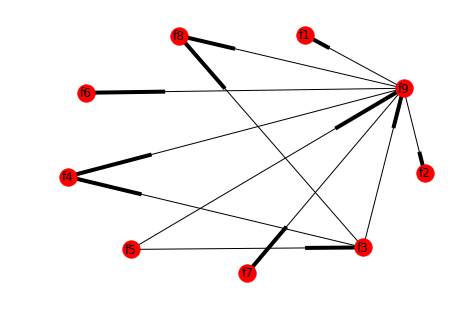

In [174]:
nx.draw(task4Model, with_labels=True)
plt.show()

In [166]:
mle = MaximumLikelihoodEstimator(task4Model, dataset2)
for var in dataset2.columns:
    task4Model.add_cpds(mle.estimate_cpd(var))

In [167]:
inferenceBN_and = VariableElimination(task4Model)

In [169]:
inferenceBN_and.map_query(list(dataset2.columns))

{'f1': 2,
 'f2': 1,
 'f3': 1,
 'f4': 0,
 'f5': 2,
 'f6': 2,
 'f7': 0,
 'f8': 2,
 'f9': 1}

In [84]:
joint_dict_and = inferenceBN_and.query(list(dataset2.columns))
temp = DiscreteFactor.product(phi1=joint_dict_and['f1'],self=joint_dict_and['f2'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and['f3'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and['f4'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and['f5'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and['f6'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and['f7'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and['f8'],inplace=False)
joint_dist_and = DiscreteFactor.product(phi1=temp,self=joint_dict_and['f9'],inplace=False)

In [85]:
joint_dist_and.assignment([np.argmin(joint_dist_and.values)])

[[('f9', 0),
  ('f6', 0),
  ('f7', 2),
  ('f8', 4),
  ('f2', 3),
  ('f3', 2),
  ('f4', 4),
  ('f5', 3),
  ('f1', 0)]]

# Task 3

In [86]:
# Converting Nw10 to markov

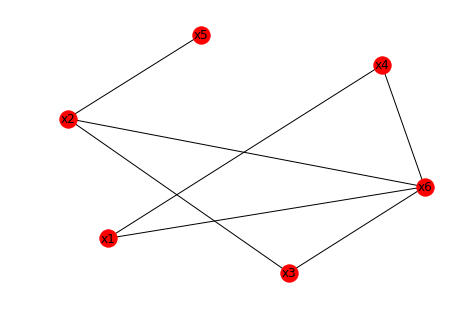

In [175]:
nw10MM = nw10.to_markov_model()
nx.draw(nw10MM, with_labels=True)
plt.show()

In [107]:
inferenceMM_th= VariableElimination(nw10MM)

In [109]:
inferenceMM_th.map_query(['x1','x2','x3','x4','x5','x6'])

{'x1': 0, 'x2': 1, 'x3': 1, 'x4': 0, 'x5': 3, 'x6': 1}

In [110]:
joint_dict_th_MM = inferenceMM_th.query(['x1','x2','x3','x4','x5','x6'])
temp = DiscreteFactor.product(phi1=joint_dict_th_MM['x1'],self=joint_dict_th_MM['x3'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_th_MM['x2'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_th_MM['x4'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_th_MM['x5'],inplace=False)
joint_dist_th_MM = DiscreteFactor.product(phi1=temp,self=joint_dict_th_MM['x6'],inplace=False)
print(joint_dist_th_MM)

+------+------+------+------+------+------+--------------------------+
| x6   | x2   | x5   | x4   | x3   | x1   |   phi(x6,x2,x5,x4,x3,x1) |
+======+======+======+======+======+======+==========================+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_0 | x1_0 |                   0.0002 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_0 | x1_1 |                   0.0000 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_0 | x1_2 |                   0.0000 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_0 | x1_3 |                   0.0000 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_1 | x1_0 |                   0.0006 |
+------+------+------+------+------+------+--------------------------+
| x6_0 | x2_0 | x5_0 | x4_0 | x3_1 | x1_1 |                   0.0000 |
+-----

In [116]:
joint_dist_th_MM.assignment([np.argmin(joint_dist_th_MM.values)])

[[('x6', 0), ('x2', 2), ('x5', 2), ('x4', 2), ('x3', 2), ('x1', 1)]]

In [104]:
# Converting and dataset to markov

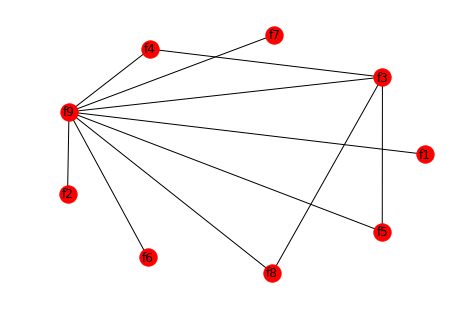

In [112]:
task4ModelMM = task4Model.to_markov_model()
nx.draw(task4ModelMM, with_labels=True)
plt.show()

In [113]:
inferenceMM_and = VariableElimination(task4ModelMM)

In [114]:
inferenceMM_and.map_query(list(dataset2.columns))

{'f1': 2,
 'f2': 1,
 'f3': 1,
 'f4': 0,
 'f5': 2,
 'f6': 2,
 'f7': 0,
 'f8': 2,
 'f9': 1}

In [115]:
joint_dict_and_MM = inferenceMM_and.query(list(dataset2.columns))
temp = DiscreteFactor.product(phi1=joint_dict_and_MM['f1'],self=joint_dict_and_MM['f2'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and_MM['f3'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and_MM['f4'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and_MM['f5'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and_MM['f6'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and_MM['f7'],inplace=False)
temp = DiscreteFactor.product(phi1=temp,self=joint_dict_and_MM['f8'],inplace=False)
joint_dist_and_MM = DiscreteFactor.product(phi1=temp,self=joint_dict_and['f9'],inplace=False)

In [117]:
joint_dist_and_MM.assignment([np.argmin(joint_dist_and_MM.values)])

[[('f9', 0),
  ('f6', 0),
  ('f7', 2),
  ('f8', 4),
  ('f2', 3),
  ('f3', 2),
  ('f4', 4),
  ('f5', 3),
  ('f1', 0)]]